In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y


In [2]:
#####################################################################
######################### IMPORT LIBRARIES ##########################
#####################################################################

In [42]:
import re
import pandas as pd 
import numpy as np 
import os 
import nltk 
import matplotlib.pyplot as plt
import shap 
from collections import Counter
from wordcloud import WordCloud

nltk.download('wordnet') 
nltk.download('omw-1.4') 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize


# Models:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/meganpete/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/meganpete/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/meganpete/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/meganpete/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
#####################################################################
############################ PREPROCESSING ##########################
#####################################################################

In [5]:
## Tokenize + clean text, convert to dataframe

# Load data
with open("data_train.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Split the text into separate abstracts
abstracts = re.split(r"[\n\s]*###\d+[\n\s]*", text)[1:]

# Tokenize and clean each sentence, and extract the label
labeled_sentences = []
tokens = []
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for abstract in abstracts:
    label_sentences = re.findall(r"(\b\w+\b)\s+(.+)", abstract)
    for label, sentence in label_sentences:
        sentence = re.sub(r'[^a-zA-Z]+',' ', sentence).strip() # Remove non alphabetic
        word_tokens = word_tokenize(sentence) # Tokenize
        cleaned_word_tokens = []
        for word in word_tokens:
            if word.lower() not in stop_words:
                word = lemmatizer.lemmatize(word) # Stem words
                cleaned_word_tokens.append(word.lower())
        cleaned_word_tokens = ' '.join(cleaned_word_tokens) # Convert to one sentence
        tokens.append(cleaned_word_tokens)
        labeled_sentences.append((label, cleaned_word_tokens)) # Add the labeled sentence to the list
        


In [6]:
# Convert to dataframe 
df = pd.DataFrame(labeled_sentences, columns = ['label','sentence'])

df = df.head(40000) #80,000 seems good for time
df


,label,sentence
0,OBJECTIVE,investigate efficacy week daily low dose oral ...
1,METHODS,total patient primary knee oa randomized recei...
2,METHODS,outcome measure included pain reduction improv...
3,METHODS,pain assessed using visual analog pain scale mm
4,METHODS,secondary outcome measure included western ont...
...,...,...
39995,METHODS,extent cad graded operator association ppci
39996,METHODS,evaluated prognostic value high sensitivity ca...
39997,METHODS,outcomes cardiovascular death cvd spontaneous ...
39998,RESULTS,angiographic data extent cad improved predicti...


In [7]:
## Create bag of words model 
corpus = list(df['sentence'])

#### Can change max features ****
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus).toarray() 
y = df['label'].values
# Split into train and test 
X_train_s, X_test_s , y_train_s, y_test_s = train_test_split(X, y , test_size = 0.20, random_state=101)

In [8]:
## Check frequecies for upsampling

# Convert y to a numpy array
y_train_np = np.array(y_train_s)

# Count the frequency of each label
label_counts = Counter(y_train_np)

# Print the frequency of each label
for label, count in label_counts.items():
    print(f"{label}: {count}")
    
# Up-sample background and objective


RESULTS: 10186
METHODS: 10546
OBJECTIVE: 2514
BACKGROUND: 3908
CONCLUSIONS: 4846


In [9]:
def count_word_types(sentence):
    tokens = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    
    word_types = {
        'Nouns': 0,
        'Verbs': 0,
        'Adjectives': 0,
        'Adverbs': 0
    }
    
    for _, pos in pos_tags:
        if pos.startswith('N'):
            word_types['Nouns'] += 1
        elif pos.startswith('V'):
            word_types['Verbs'] += 1
        elif pos.startswith('J'):
            word_types['Adjectives'] += 1
        elif pos.startswith('R'):
            word_types['Adverbs'] += 1
    
    return word_types

# Apply the count_word_types function to each sentence in the DataFrame
df['word_types'] = df['sentence'].apply(count_word_types)

# Convert the dictionaries in the 'word_types' column to a DataFrame
word_types_df = pd.DataFrame(df['word_types'].tolist())

# Concatenate the original DataFrame with the new word_types_df DataFrame
df = pd.concat([df.drop(columns=['word_types']), word_types_df], axis=1)

# Group by label and sum the word type counts
word_type_totals = df.groupby('label')[['Nouns', 'Verbs', 'Adjectives', 'Adverbs']].sum()

# Calculate the total number of words for each label
total_words = word_type_totals.sum(axis=1)

# Calculate the percentage of word types for each label
word_type_percentages = word_type_totals.div(total_words, axis=0) * 100

# Round the numbers in the DataFrame to 2 decimal places
word_type_percentages_rounded = word_type_percentages.round(2)

# Print the results
print(word_type_percentages_rounded)


             Nouns  Verbs  Adjectives  Adverbs
label                                         
BACKGROUND   55.36  15.74       24.98     3.92
CONCLUSIONS  54.86  16.30       24.42     4.42
METHODS      58.02  17.06       21.95     2.97
OBJECTIVE    58.96  13.93       24.47     2.64
RESULTS      60.17  13.66       21.21     4.96


In [10]:
#####################################################################
############################ RUN MODELS  ############################
#####################################################################


In [11]:
## Random forest model 

def classification_report_with_auc(y_true, y_pred, y_probs, classes):
    # Compute precision, recall, F1-score
    report = precision_recall_fscore_support(y_true, y_pred)

    # Compute ROC AUC for each class
    y_true_bin = label_binarize(y_true, classes=classes)
    auc_scores = [roc_auc_score(y_true_bin[:, i], y_probs[:, i]) for i in range(len(classes))]

    # Create a DataFrame to display the results
    report_df = pd.DataFrame({
        'Class': classes,
        'Precision': report[0],
        'Recall': report[1],
        'F1-score': report[2],
        'AUC': auc_scores
    })

    # Round values to 2 decimal places
    report_df = report_df.round(2)

    return report_df

# Run random forest with best parameters
rf_best = RandomForestClassifier(n_estimators=300, min_samples_split=10, max_depth=100)
rf_best.fit(X_train_s, y_train_s)

# Get predictions and probabilities
predictions_test = rf_best.predict(X_test_s)
y_test_probs = rf_best.predict_proba(X_test_s)

predictions_train = rf_best.predict(X_train_s)
y_train_probs = rf_best.predict_proba(X_train_s)

# Get unique classes
unique_classes = np.unique(y_train_s)

# Print custom classification report with AUC for the test set
print("Test set:")
report_df_test = classification_report_with_auc(y_test_s, predictions_test, y_test_probs, unique_classes)
print(report_df_test)

# Print custom classification report with AUC for the training set
print("\nTraining set:")
report_df_train = classification_report_with_auc(y_train_s, predictions_train, y_train_probs, unique_classes)
print(report_df_train)


Test set:
         Class  Precision  Recall  F1-score   AUC
0   BACKGROUND       0.60    0.34      0.44  0.88
1  CONCLUSIONS       0.62    0.46      0.53  0.88
2      METHODS       0.70    0.87      0.78  0.93
3    OBJECTIVE       0.62    0.47      0.53  0.90
4      RESULTS       0.74    0.81      0.78  0.92

Training set:
         Class  Precision  Recall  F1-score   AUC
0   BACKGROUND       0.96    0.87      0.91  1.00
1  CONCLUSIONS       0.98    0.89      0.93  0.99
2      METHODS       0.88    0.99      0.93  0.99
3    OBJECTIVE       1.00    0.86      0.93  0.99
4      RESULTS       0.97    0.95      0.96  0.99


In [12]:
## Logistic regression model

# Use the custom function defined earlier

# Run logistic regression with best parameters
logistic_best = LogisticRegression(C=10, penalty='l2')
logistic_best.fit(X_train_s, y_train_s)

# Get predictions and probabilities
predictions_test_log = logistic_best.predict(X_test_s)
y_test_probs_log = logistic_best.predict_proba(X_test_s)

predictions_train_log = logistic_best.predict(X_train_s)
y_train_probs_log = logistic_best.predict_proba(X_train_s)

# Get unique classes
unique_classes = np.unique(y_train_s)

# Print custom classification report with AUC for the test set
print("Logistic Regression Test set:")
report_df_test_log = classification_report_with_auc(y_test_s, predictions_test_log, y_test_probs_log, unique_classes)
print(report_df_test_log)

# Print custom classification report with AUC for the training set
print("\nLogistic Regression Training set:")
report_df_train_log = classification_report_with_auc(y_train_s, predictions_train_log, y_train_probs_log, unique_classes)
print(report_df_train_log)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression Test set:
         Class  Precision  Recall  F1-score   AUC
0   BACKGROUND       0.52    0.50      0.51  0.89
1  CONCLUSIONS       0.60    0.55      0.57  0.89
2      METHODS       0.80    0.83      0.82  0.94
3    OBJECTIVE       0.55    0.49      0.52  0.91
4      RESULTS       0.77    0.80      0.79  0.93

Logistic Regression Training set:
         Class  Precision  Recall  F1-score   AUC
0   BACKGROUND       0.60    0.58      0.59  0.92
1  CONCLUSIONS       0.66    0.61      0.63  0.92
2      METHODS       0.82    0.87      0.84  0.95
3    OBJECTIVE       0.66    0.53      0.59  0.94
4      RESULTS       0.81    0.83      0.82  0.95


In [13]:
#####################################################################
############################ UPSAMPLING  ############################
#####################################################################


In [14]:

# # Convert NumPy arrays to pandas DataFrames
# X_train_s_df = pd.DataFrame(X_train_s)
# y_train_s_df = pd.DataFrame(y_train_s, columns=['label'])  


# # Combine X_train_s and y_train_s into a single DataFrame
# train_data = pd.concat([X_train_s_df.reset_index(drop=True), y_train_s_df.reset_index(drop=True)], axis=1)

# # Separate the majority and minority classes
# majority_class = train_data[~train_data['label'].isin(['OBJECTIVE', 'BACKGROUND'])]  
# minority_class_1 = train_data[train_data['label'] == 'OBJECTIVE']  
# minority_class_2 = train_data[train_data['label'] == 'BACKGROUND']  

# # Upsample the minority classes
# minority_upsampled_1 = resample(minority_class_1, replace=True, n_samples=len(majority_class), random_state=42)
# minority_upsampled_2 = resample(minority_class_2, replace=True, n_samples=len(majority_class), random_state=42)

# # Combine the majority class and upsampled minority classes
# train_data_upsampled = pd.concat([majority_class, minority_upsampled_1, minority_upsampled_2])

# # Split the upsampled data back into X_train_s and y_train_s
# X_train_s_upsampled = train_data_upsampled.drop('label', axis=1).values  
# y_train_s_upsampled = train_data_upsampled['label'].values  



In [15]:
# # Run RandomForestClassifier with the upsampled data
# rf_best = RandomForestClassifier(n_estimators=300, min_samples_split=10, max_depth=100)
# rf_best.fit(X_train_s_upsampled, y_train_s_upsampled)

# # Print results
# predictions = rf_best.predict(X_test_s)
# print("Test set:")
# print(classification_report(y_test_s, predictions))

# predictions_train = rf_best.predict(X_train_s_upsampled)
# print("Training set:")
# print(classification_report(y_train_s_upsampled, predictions_train))

In [16]:
# # Run logistic with the upsampled data

# logistic_best = LogisticRegression(C=10, penalty='l2')
# logistic_best.fit(X_train_s_upsampled, y_train_s_upsampled)

# # Print results
# predictions = logistic_best.predict(X_test_s)
# print("Test set:")
# print(classification_report(y_test_s, predictions))

# predictions_train = logistic_best.predict(X_train_s_upsampled)
# print("Training set:")
# print(classification_report(y_train_s_upsampled, predictions_train))

In [17]:
#####################################################################
######################## FEATURE IMPORTANCE #########################
#####################################################################

In [18]:
# Feature importance logistic  
# Get feature names from TfidfVectorizer used in cross-validation
feature_names = vectorizer.get_feature_names()

# Get feature importances
importances = abs(logistic_best.coef_[0])
feature_importances_logistic = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort features by importance
feature_importances_logistic = feature_importances_logistic.sort_values('importance', ascending=False)
feature_importances_logistic = feature_importances_logistic.reset_index(drop=True)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [39]:

#'logistic_best' is the trained LogisticRegression model
coefficients = logistic_best.coef_

# Calculate the absolute values of coefficients
abs_coefficients = np.abs(coefficients)

# Calculate the sum of the absolute values
sum_abs_coefficients = np.sum(abs_coefficients)

# Normalise the feature importances by dividing each value by the sum
normalised_feature_importances = abs_coefficients / sum_abs_coefficients

# Print the normalised feature importances
print(normalised_feature_importances)


[[1.52041956e-04 1.40576064e-04 9.89961273e-05 ... 2.17720621e-04
  3.99578842e-04 3.34689695e-04]
 [9.95440827e-05 1.35871689e-04 7.24784289e-05 ... 2.19847791e-04
  2.39555942e-05 2.34834171e-04]
 [9.20084914e-05 6.38858048e-06 1.89509258e-04 ... 1.52823957e-04
  2.10396768e-04 1.65192485e-04]
 [3.47366340e-05 1.97556346e-06 3.01532811e-04 ... 1.54497353e-04
  6.54566754e-05 2.80688758e-05]
 [3.08857896e-04 2.80860770e-04 8.55058540e-05 ... 1.30247102e-04
  9.97698048e-05 4.32400257e-04]]


In [43]:
# Feature importance random forest  
feature_importances_rf = pd.DataFrame(rf_best.feature_importances_,
                                   index = vectorizer.get_feature_names(),
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances_rf = feature_importances_rf.reset_index()
feature_importances_rf = feature_importances_rf.rename(columns={'index':'feature'})
feature_importances_rf = feature_importances_rf.reset_index(drop=True)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [52]:
print("Feature importance RF:")
feature_importances_rf

Feature importance RF:


,feature,importance
0,group,0.034273
1,significantly,0.021605
2,significant,0.018061
3,randomized,0.018016
4,may,0.014306
...,...,...
995,item,0.000083
996,mmol,0.000079
997,ng,0.000072
998,face,0.000067


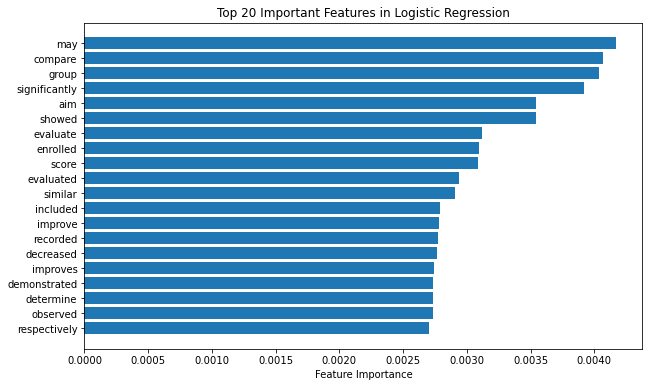

In [72]:
import matplotlib.pyplot as plt

# For logistic regression, first create a DataFrame of feature importances
coefficients = logistic_best.coef_
abs_coefficients = np.abs(coefficients)
average_coefficients = np.mean(abs_coefficients, axis=0)
normalised_feature_importances = average_coefficients / np.sum(average_coefficients)
feature_importances_logistic = pd.DataFrame({'feature': vectorizer.get_feature_names(), 'importance': normalised_feature_importances})
feature_importances_logistic = feature_importances_logistic.sort_values('importance', ascending=False)

top_n = 20
top_features_logistic = feature_importances_logistic.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features_logistic['feature'], top_features_logistic['importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Important Features in Logistic Regression')
plt.show()


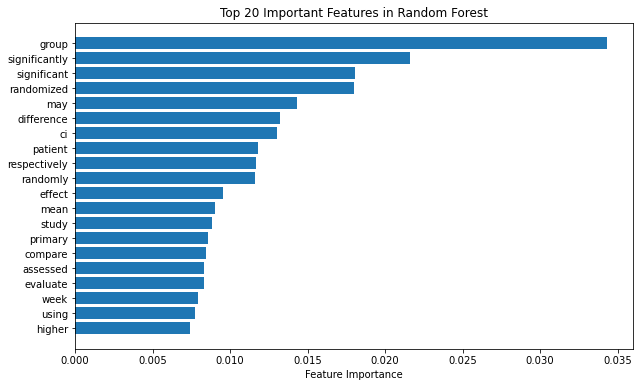

In [68]:

top_n = 20
top_features_rf = feature_importances_rf.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features_rf['feature'], top_features_rf['importance'], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Important Features in Random Forest')
plt.show()


In [73]:
k = 20
top_features_rf = feature_importances_rf.head(k)
top_features_logistic = feature_importances_logistic.head(k)

count = 0 
for word in top_features_rf['feature'].values:
    if word in top_features_logistic['feature'].values:
        count = count + 1    
print(count)

6


In [24]:
 ## Parameter tuning for random forest 

 param_grid_rf = {
     'n_estimators': [50, 100, 300]
     'max_depth': [None, 10, 100],
     'min_samples_split': [2, 5, 10]
 }

 rf = RandomForestClassifier()
 grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5)
 grid_search_rf.fit(X_train_s, y_train_s)

 print(f'The best parameters are: {grid_search_rf.best_params_}')
 print(f'The best validation accuracy is: {grid_search_rf.best_score_}')

 # Evaluate on test set
 rf_best = grid_search_rf.best_estimator_
 print(f'The test accuracy is: {accuracy_score(y_test_s, rf_best.predict(X_test_s))}')

 # {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}

In [25]:
 ## Parameter tuning for logistic regression 

 logistic = LogisticRegression() 

 param_grid_logistic = {
     'penalty': ['l1', 'l2'],
     'C': [0.01, 0.1, 1, 10, 100]
 }

grid_search_logistic = GridSearchCV(logistic, param_grid_logistic, cv=5)
grid_search_logistic.fit(X_train_s, y_train_s)

print(f'The best parameters are: {grid_search_logistic.best_params_}')
print(f'The best validation accuracy is: {grid_search_logistic.best_score_}')



